### Read OISST v2 data via Thredds, remap data to the POP2 1 deg. grid, and test the marineHeatWaves algorithm

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import xesmf
import pop_tools
import xarray as xr
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

In [2]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
files = [f'{base_url}sst.day.mean.{year}.v2.nc' for year in range(1981, 2021)]
#files
#https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc.html

In [3]:
%%time
data = xr.open_mfdataset(files)

CPU times: user 502 ms, sys: 84.8 ms, total: 587 ms
Wall time: 4.51 s


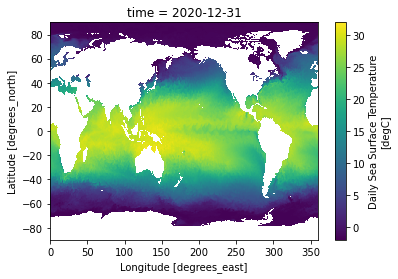

In [4]:
%matplotlib inline
data.sst[-1,:].plot(vmin=-2,vmax=32)

### Remap SST to POP_gx1v7

In [5]:
%%time
ds_sst = data.sst.sel(time = slice("1982-01-01","2014-12-31"))

CPU times: user 5.28 ms, sys: 0 ns, total: 5.28 ms
Wall time: 5.29 ms


In [6]:
#ds_sst

In [7]:
pop_grd = pop_tools.get_grid('POP_gx1v7').rename({'TLONG': 'lon',
                                             'TLAT': 'lat', 
                                             'ULONG': 'lon_b',
                                             'ULAT': 'lat_b',})
#pop_grd

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
# create new dataarray
ny, nx = pop_grd.lon.shape
nt = len(ds_sst.time)
tmp = np.zeros((nt,ny,nx))

da_out = xr.DataArray(
    data=tmp,
    dims=["time", "nlat", "nlon"],
    coords=dict(
        lon=(["nlat", "nlon"], pop_grd.lon.values),
        lat=(["nlat", "nlon"], pop_grd.lat.values),
        time=ds_sst.time.values,
    ),
    attrs=dict(
        description="SST interpolated to POP_gx1v7",
        units="degC",
    ),
)
#da_out

In [9]:
regrid = xesmf.Regridder(
        ds_sst,
        da_out,
        method='bilinear',
        periodic=True,
    )

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask/array/core.py:405: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [12]:
%%time
for t in range(1200):
    da_out[t,:] = regrid(ds_sst[t,:])

CPU times: user 1min 8s, sys: 8.12 s, total: 1min 16s
Wall time: 2min 46s


In [25]:
da_out.to_netcdf('sst_interpolated.nc')

#### Repeat case study #1: 2011 Western Australia event
As an example, let's load a daily time series of SST off Western Australia (WA; 112.5 ∘ E, 29.5 ∘ S) over the 1982 to 2014 period, remotely-sensed from the AVHRR satellite platform:

In [18]:
%%time
wa_ds = da_out.isel(nlon = 135, nlat = 93).load()

CPU times: user 433 µs, sys: 52 µs, total: 485 µs
Wall time: 494 µs


In [19]:
#wa_ds.to_netcdf('wa_ds.nc')

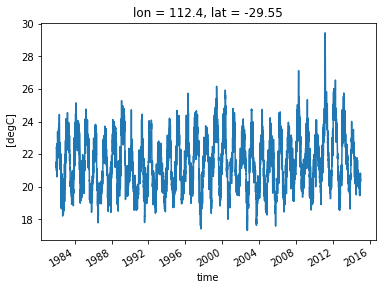

In [16]:
wa_ds.plot()

Next we run the MHW detection algorithm which returns the variable mhws, consisting of the detected MHWs, and clim, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:

In [19]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [20]:
mhws, clim = mhw.detect(t, wa_ds.values)

This algorithm has detected the following number of MHW events:

In [21]:
mhws['n_events']

60

The first ten events, for example, have the following maximum intensities (in C)  

In [22]:
mhws['intensity_max'][0:10]

[1.3277945637565232,
 1.89788758747315,
 2.2341555672773303,
 2.2357690599794644,
 1.7692741437095165,
 1.7350290726102635,
 1.842070506221404,
 2.0434193919205654,
 1.9530746161985348,
 1.711445850022134]

Let's have a look at some properties of the event with the largest maximum intensity

In [23]:
ev = np.argmax(mhws['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws['duration'][ev], 'days')
print ('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 6.354586185735677 deg. C
Average intensity: 3.289632556178954 deg. C
Cumulative intensity: 177.6401580336635 deg. C-days
Duration: 54 days
Start date: 07 February 2011
End date: 01 April 2011


This turns out to be the infamous 2011 MHW off WA. Let's plot the SST time series over the full record and also have a closer look at the identified MHW event:

Text(0, 0.5, 'SST [$^\\circ$C]')

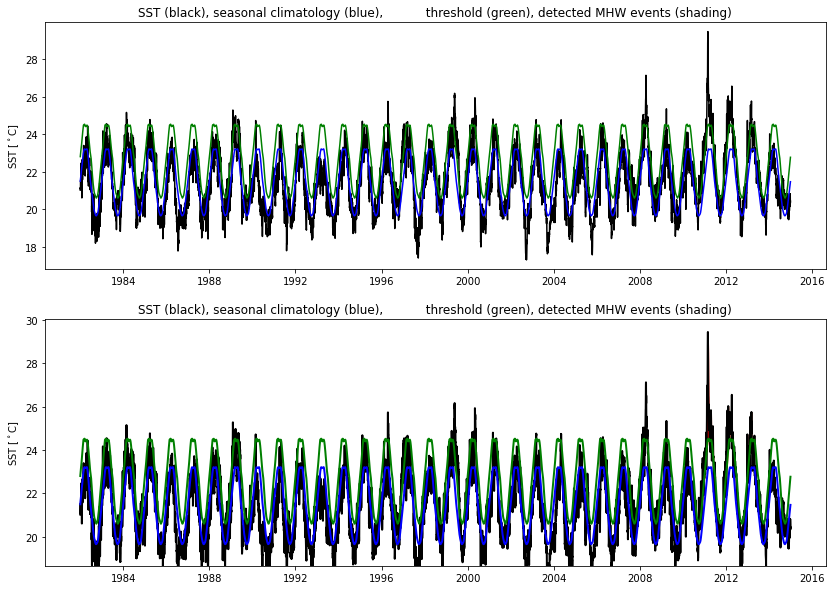

In [24]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, wa_ds.values, 'k-')
plt.plot(dates, clim['thresh'], 'g-')
plt.plot(dates, clim['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(t[0], t[-1])
plt.ylim(wa_ds.min()-0.5, wa_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2011 WA event) and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, wa_ds, 'k-', linewidth=2)
plt.plot(dates, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

In [43]:
len(mhws['category'])

60